In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# Helper functions
from helper_functions import get_bitcoin_df, create_dataset_with_look_back

# Needed imports
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
from prophet import Prophet

In [33]:
# Get the dataframe
btc_df = get_bitcoin_df()
btc_df.head()

,date,open,high,low,close,volume_btc,volume_usd
0,2017-01-01,977.256602,977.385233,977.132620,977.276060,4.760662,4701.831942
1,2017-01-02,1012.267604,1012.517181,1011.988826,1012.273903,5.671792,5747.243606
2,2017-01-03,1020.001535,1020.226840,1019.794437,1020.040472,6.312263,6442.176792
3,2017-01-04,1076.558840,1077.271167,1075.572542,1076.553639,14.973928,16303.129214
4,2017-01-05,1043.608646,1044.905549,1042.094125,1043.547951,25.013098,25132.509465


In [34]:
# Select data range
bitcoin_dataframe = btc_df[(btc_df['date'] < '2022-02-01') & (btc_df['date'] > '2019-12-31')]

In [35]:
# Create train/test set
train_size = int(0.7 * len(bitcoin_dataframe))
test_size = len(bitcoin_dataframe) - train_size

univariate_df = bitcoin_dataframe[['date', 'close']].copy()
# For Prophet to work
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print("Train size: ", len(x_train), "Test size:", len(x_valid))

Train size:  533 Test size: 229


In [36]:
# Prophet model
model = Prophet()
model.fit(train)

21:22:21 - cmdstanpy - INFO - Chain [1] start processing
21:22:21 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
# Prediction
future = model.make_future_dataframe(periods=len(x_valid), freq='D')
y_pred = model.predict(future)
print(y_pred)

            ds         trend   yhat_lower    yhat_upper  trend_lower  \
0   2020-01-01   8227.108495  3518.740346  13417.215251  8227.108495   
1   2020-01-02   8223.494967  3428.563436  13515.917340  8223.494967   
2   2020-01-03   8219.881439  3170.250842  12790.620190  8219.881439   
3   2020-01-04   8216.267912  3598.706263  13101.126706  8216.267912   
4   2020-01-05   8212.654384  3153.238531  12775.357064  8212.654384   
..         ...           ...          ...           ...          ...   
757 2022-01-27  23426.762838 -4751.247503  49670.020593 -4802.512153   
758 2022-01-28  23334.925365 -4858.270706  48897.904125 -5114.154872   
759 2022-01-29  23243.087892 -5671.210829  50328.821195 -5443.572996   
760 2022-01-30  23151.250418 -5348.203624  48314.877351 -5726.900022   
761 2022-01-31  23059.412945 -6465.802632  50100.761719 -5970.443152   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0     8227.108495       19.494579             19.49457

In [38]:
# Calculate metrics
score_mae = mean_absolute_error(y_valid, y_pred.yhat.values[-len(x_valid):])
score_rmse =  math.sqrt(mean_squared_error(y_valid, y_pred.yhat.values[-len(x_valid):]))
score_r2 = r2_score(y_valid, y_pred.yhat.values[-len(x_valid):])

print("RMSE: {}".format(score_rmse))
print("R2: {}".format(score_r2))

RMSE: 18850.340744235757
R2: -2.976076435372666


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(90.84722222222221, 0.5, 'Close')

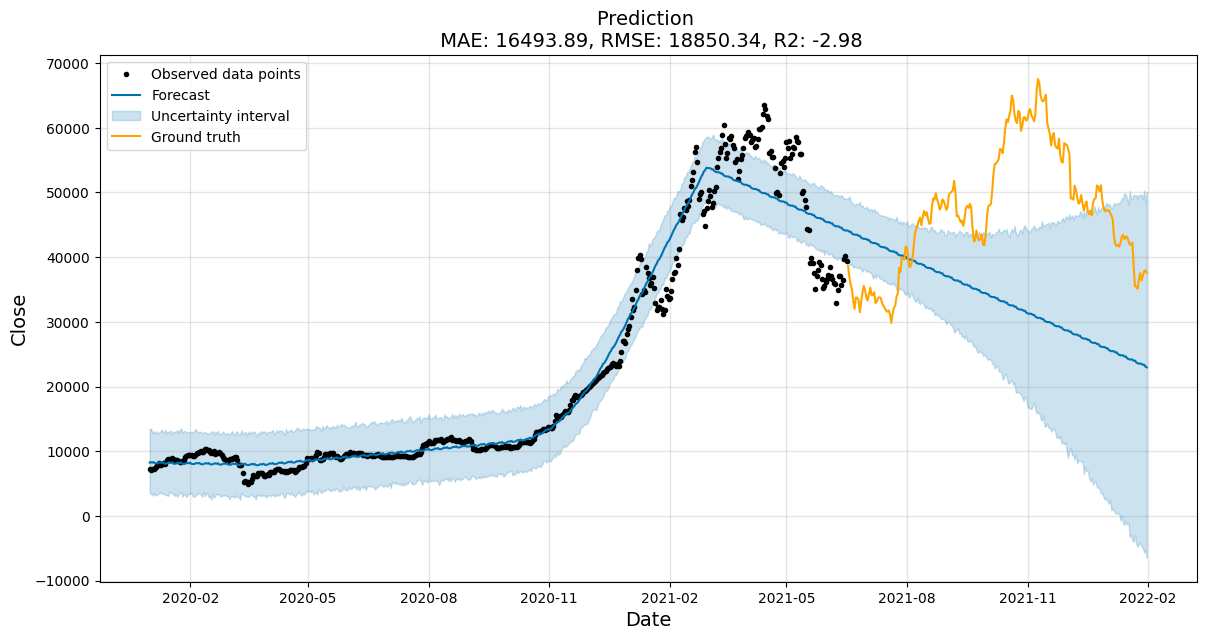

In [40]:
fig, ax = plt.subplots(1, figsize=(12, 6))
model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}, R2: {score_r2:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Close', fontsize=14)